# Ecuación de Poisson no lineal

Para resolver el problema, necesitamos elegir el lado derecho $f$, el coeficiente $q(u)$ y el valor límite $u_D$. Anteriormente, hemos trabajado con soluciones fabricadas que se pueden reproducir sin errores de aproximación. Esto es más difícil en problemas no lineales y el álgebra es más tedioso. Sin embargo, podemos utilizar SymPy para la computación simbólica e integrar dichos cálculos en el solucionador FEniCS. Esto nos permite experimentar fácilmente con diferentes soluciones fabricadas. El próximo código con SymPy requiere cierta familiaridad básica con este paquete. En particular, usaremos las funciones de SymPy diff para la diferenciación simbólica y ccode para la generación de código C/C++.

In [1]:
"""
FEniCS tutorial demo program: Nonlinear Poisson equation.

  -div(q(u)*grad(u)) = f   in the unit square.
                   u = u_D on the boundary.
"""

'\nFEniCS tutorial demo program: Nonlinear Poisson equation.\n\n  -div(q(u)*grad(u)) = f   in the unit square.\n                   u = u_D on the boundary.\n'

In [2]:
from __future__ import print_function

In [3]:
# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.
from fenics import *

In [4]:
def q(u):
    "Return nonlinear coefficient"
    return 1 + u**2

In [5]:
# Use SymPy to compute f from the manufactured solution u
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)


u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


In [6]:
# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

In [8]:
# Define boundary condition
u_D = Expression(u_code, degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

In [9]:
# Define variational problem
u = Function(V)  # Note: not TrialFunction!
v = TestFunction(V)
f = Expression(f_code, degree=2)
F = q(u)*dot(grad(u), grad(v))*dx - f*v*dx

Calling FFC just-in-time (JIT) compiler, this may take some time.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.533e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.614e+01 (tol = 1.000e-10) r (rel) = 5.767e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.883e+01 (tol = 1.000e-10) r (rel) = 1.739e+00 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.293e+01 (tol = 1.000e-10) r (rel) = 5.058e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 4.990e+00 (tol = 1.000e-10) r (rel) = 1.101e-01 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.970e-01 (tol = 1.000e-10) r (rel) = 8.758e-03 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.964e-03 (tol = 1.000e-10) r (rel) = 6.539e-05 (tol = 1.000e-09)
  Newton iteration 7: 

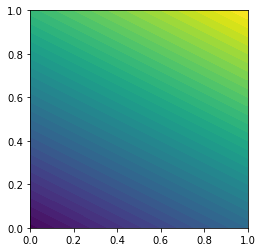

In [10]:
# Compute solution
solve(F == 0, u, bc)

# Plot solution
plot(u)

In [11]:
# Compute maximum error at vertices. This computation illustrates
# an alternative to using compute_vertex_values as in poisson.py.
u_e = interpolate(u_D, V)
import numpy as np
error_max = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
print('error_max = ', error_max)

error_max =  0.0


La principal diferencia con un problema lineal es que la función desconocida u en la forma variacional en el caso no lineal debe definirse como una función, no como una función de prueba. En cierto sentido, esto es una simplificación del caso lineal en el que debemos definir u primero como una función de prueba y luego como una función.

La función de resolución toma las ecuaciones no lineales, deriva simbólicamente la matriz jacobiana y ejecuta un método de Newton para calcular la solución.

Cuando ejecutamos el código, FEniCS informa sobre el progreso de las iteraciones de Newton. Con $2 \dot (8 \times 8)$ celdas, alcanzamos la convergencia en ocho iteraciones con una tolerancia de 10−9, y el error en la solución numérica es de aproximadamente $10^{-16}$. Estos resultados traen evidencia para una correcta implementación. Pensando en términos de diferencias finitas en una malla uniforme, los elementos $P_1$ imitan las diferencias estándar de segundo orden, que calculan exactamente la derivada de una función lineal o cuadrática. Aquí, $\nabla u$ es un vector constante, pero luego se multiplica por $(1+u^2)$, que es un polinomio de segundo orden en $x$ e $y$, que el "operador de diferencia" de divergencia debería calcular exactamente. Por lo tanto, incluso con elementos $P_1$, podemos esperar que la $u$ fabricada sea reproducida por el método numérico. Con una no linealidad como $1+u^4$, este no será el caso y, en su lugar, tendríamos que verificar las tasas de convergencia.

El ejemplo actual muestra lo fácil que es resolver un problema no lineal en FEniCS. Sin embargo, los expertos en la solución numérica de PDE no lineales saben muy bien que los procedimientos automatizados pueden fallar para problemas no lineales, y que a menudo es necesario tener un control manual del proceso de solución mucho mejor que el que tenemos en el caso actual. Volvemos a este problema en [23] y mostramos cómo podemos implementar algoritmos de solución personalizados para ecuaciones no lineales y también cómo podemos dirigir los parámetros en el método de Newton automatizado utilizado anteriormente.